# Analysis
Perform **exploratory data analysis** on the dataset, then preprocess for machine learning model training.

*The following analysis follows work by [Randrita Sarkar](https://www.kaggle.com/code/randritasarkar/ship-detection).*
*Refactoring and consolidation done by [Christian Decker](https://github.com/cmdecker95).*

In [2]:
import json

import matplotlib.pylab as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

In [3]:
# Import dataset (download link in README)
with open('./archive/shipsnet.json') as file:
    shipsnet_data = json.load(file)

In [4]:
# Preview the dataset
pd.DataFrame(shipsnet_data).head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


For this section, we will focus only on the `data` and `labels` features of the dataset. Each row is an image, where its entry in `data` is a list of 19,200 values between 0 and 255. These values represent the intensities of the red, green, and blue channels of each pixel in that particular 80x80 RGB image. As for `labels`, a `1` represents a ship contained in the image.

In [5]:
# Pick out image features and target labels
images = np.array(shipsnet_data['data']).astype('uint8')
labels = np.array(shipsnet_data['labels']).astype('uint8')

print(f"{images.shape=}")
print(f"{labels.shape=}")

images.shape=(4000, 19200)
labels.shape=(4000,)


In [6]:
# Reshape 19,200 8-bit integer values into 80x80 RGB pixel intensities
X = images.reshape([-1, 3, 80, 80]).transpose([0, 2, 3, 1])
X = X / 255 # normalize RGB pixel values
y = to_categorical(labels, 2)

print(f"{X.shape=}")
print(f"{y.shape=}")

X.shape=(4000, 80, 80, 3)
y.shape=(4000, 2)


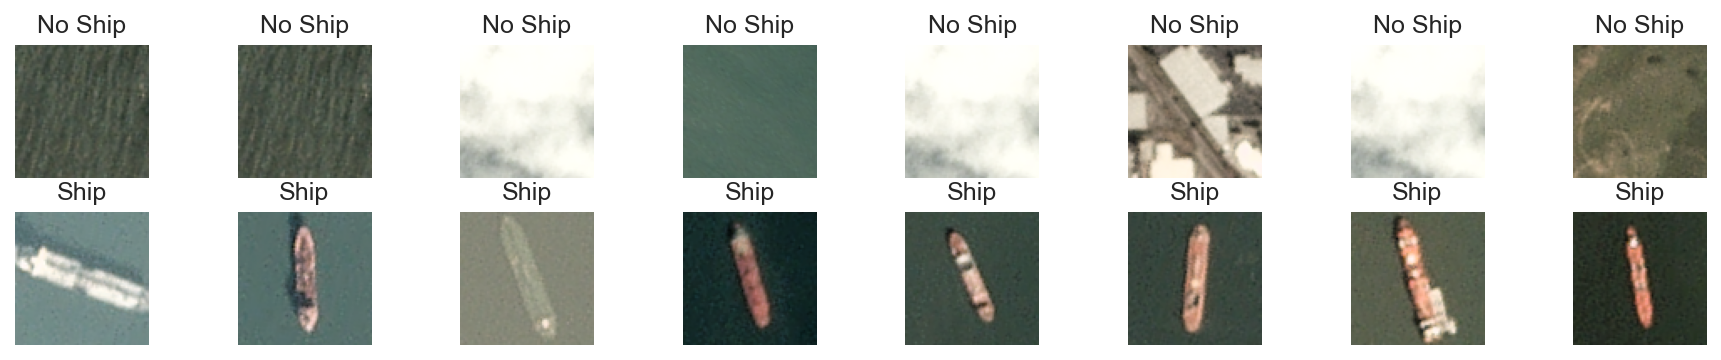

In [7]:
# Visualize the preprocessed dataset
not_ships = X[labels==0]
are_ships = X[labels==1]

plt.style.use('seaborn')
plt.figure(figsize=(15, 5), dpi=150)

for i in range(16):
    if i < 8:
        plt.subplot(2, 8, i + 1)
        plt.title('No Ship')
        plt.imshow(not_ships[i + np.random.randint(100, 200)])
        plt.axis("off")
    else:
        plt.subplot(2, 8, i + 1)
        plt.title('Ship')
        plt.imshow(are_ships[i + np.random.randint(100, 200)])
        plt.axis("off")

plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0.25)
plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val,  y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

print(f"{X_train.shape=}")
print(f"{X_val.shape=}")
print(f"{X_test.shape=}")
print(f"{y_train.shape=}")
print(f"{y_val.shape=}")
print(f"{y_test.shape=}")

X_train.shape=(2400, 80, 80, 3)
X_val.shape=(800, 80, 80, 3)
X_test.shape=(800, 80, 80, 3)
y_train.shape=(2400, 2)
y_val.shape=(800, 2)
y_test.shape=(800, 2)


# Model
Train a **convolutional neural network** (CNN) to classify an image as either containing a ship or not.

*The following model design follows work by [Randrita Sarkar](https://www.kaggle.com/code/randritasarkar/ship-detection).*
*Refactoring and consolidation done by [Christian Decker](https://github.com/cmdecker95).*

In [9]:
# Design and compile the CNN in a sequential architecture
model = Sequential([

    # convolution
    Conv2D(64, 4, padding='same', activation='relu', input_shape=(80, 80, 3)),
    MaxPool2D(5),
    Dropout(0.25),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPool2D(3, 1),
    Dropout(0.25),
    Conv2D(16, 2, padding='same', activation='relu'),
    MaxPool2D(3, 1),
    Dropout(0.25),

    # fully connected
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 64)        3136      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 32)        0

In [10]:
# Train the model
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[EarlyStopping(monitor='val_loss',
                                               mode='min', patience=10,
                                               restore_best_weights=True)])

Epoch 1/100


2022-05-03 16:53:46.974326: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


75/75 [==============================] - 5s 55ms/step - loss: 0.6181 - accuracy: 0.7217 - val_loss: 0.5953 - val_accuracy: 0.7487
Epoch 2/100
75/75 [==============================] - 4s 55ms/step - loss: 0.5457 - accuracy: 0.7579 - val_loss: 0.5549 - val_accuracy: 0.7487
Epoch 3/100
75/75 [==============================] - 4s 59ms/step - loss: 0.4518 - accuracy: 0.7583 - val_loss: 0.3824 - val_accuracy: 0.7487
Epoch 4/100
75/75 [==============================] - 4s 57ms/step - loss: 0.3582 - accuracy: 0.7579 - val_loss: 0.3250 - val_accuracy: 0.7487
Epoch 5/100
75/75 [==============================] - 5s 67ms/step - loss: 0.3411 - accuracy: 0.8592 - val_loss: 0.2942 - val_accuracy: 0.8938
Epoch 6/100
75/75 [==============================] - 4s 58ms/step - loss: 0.3016 - accuracy: 0.8958 - val_loss: 0.2974 - val_accuracy: 0.9062
Epoch 7/100
75/75 [==============================] - 5s 60ms/step - loss: 0.2636 - accuracy: 0.9013 - val_loss: 0.2159 - val_accuracy: 0.9388
Epoch 8/100
75/75 

In [14]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)

25/25 [==============================] - 1s 22ms/step - loss: 0.0492 - accuracy: 0.9862


In [15]:
fit_history = pd.DataFrame(history.history)
fit_history.describe().loc[['min', 'mean', 'max'], ['accuracy', 'val_accuracy']]

,accuracy,val_accuracy
min,0.721667,0.74875
mean,0.934065,0.94225
max,0.986250,0.98750


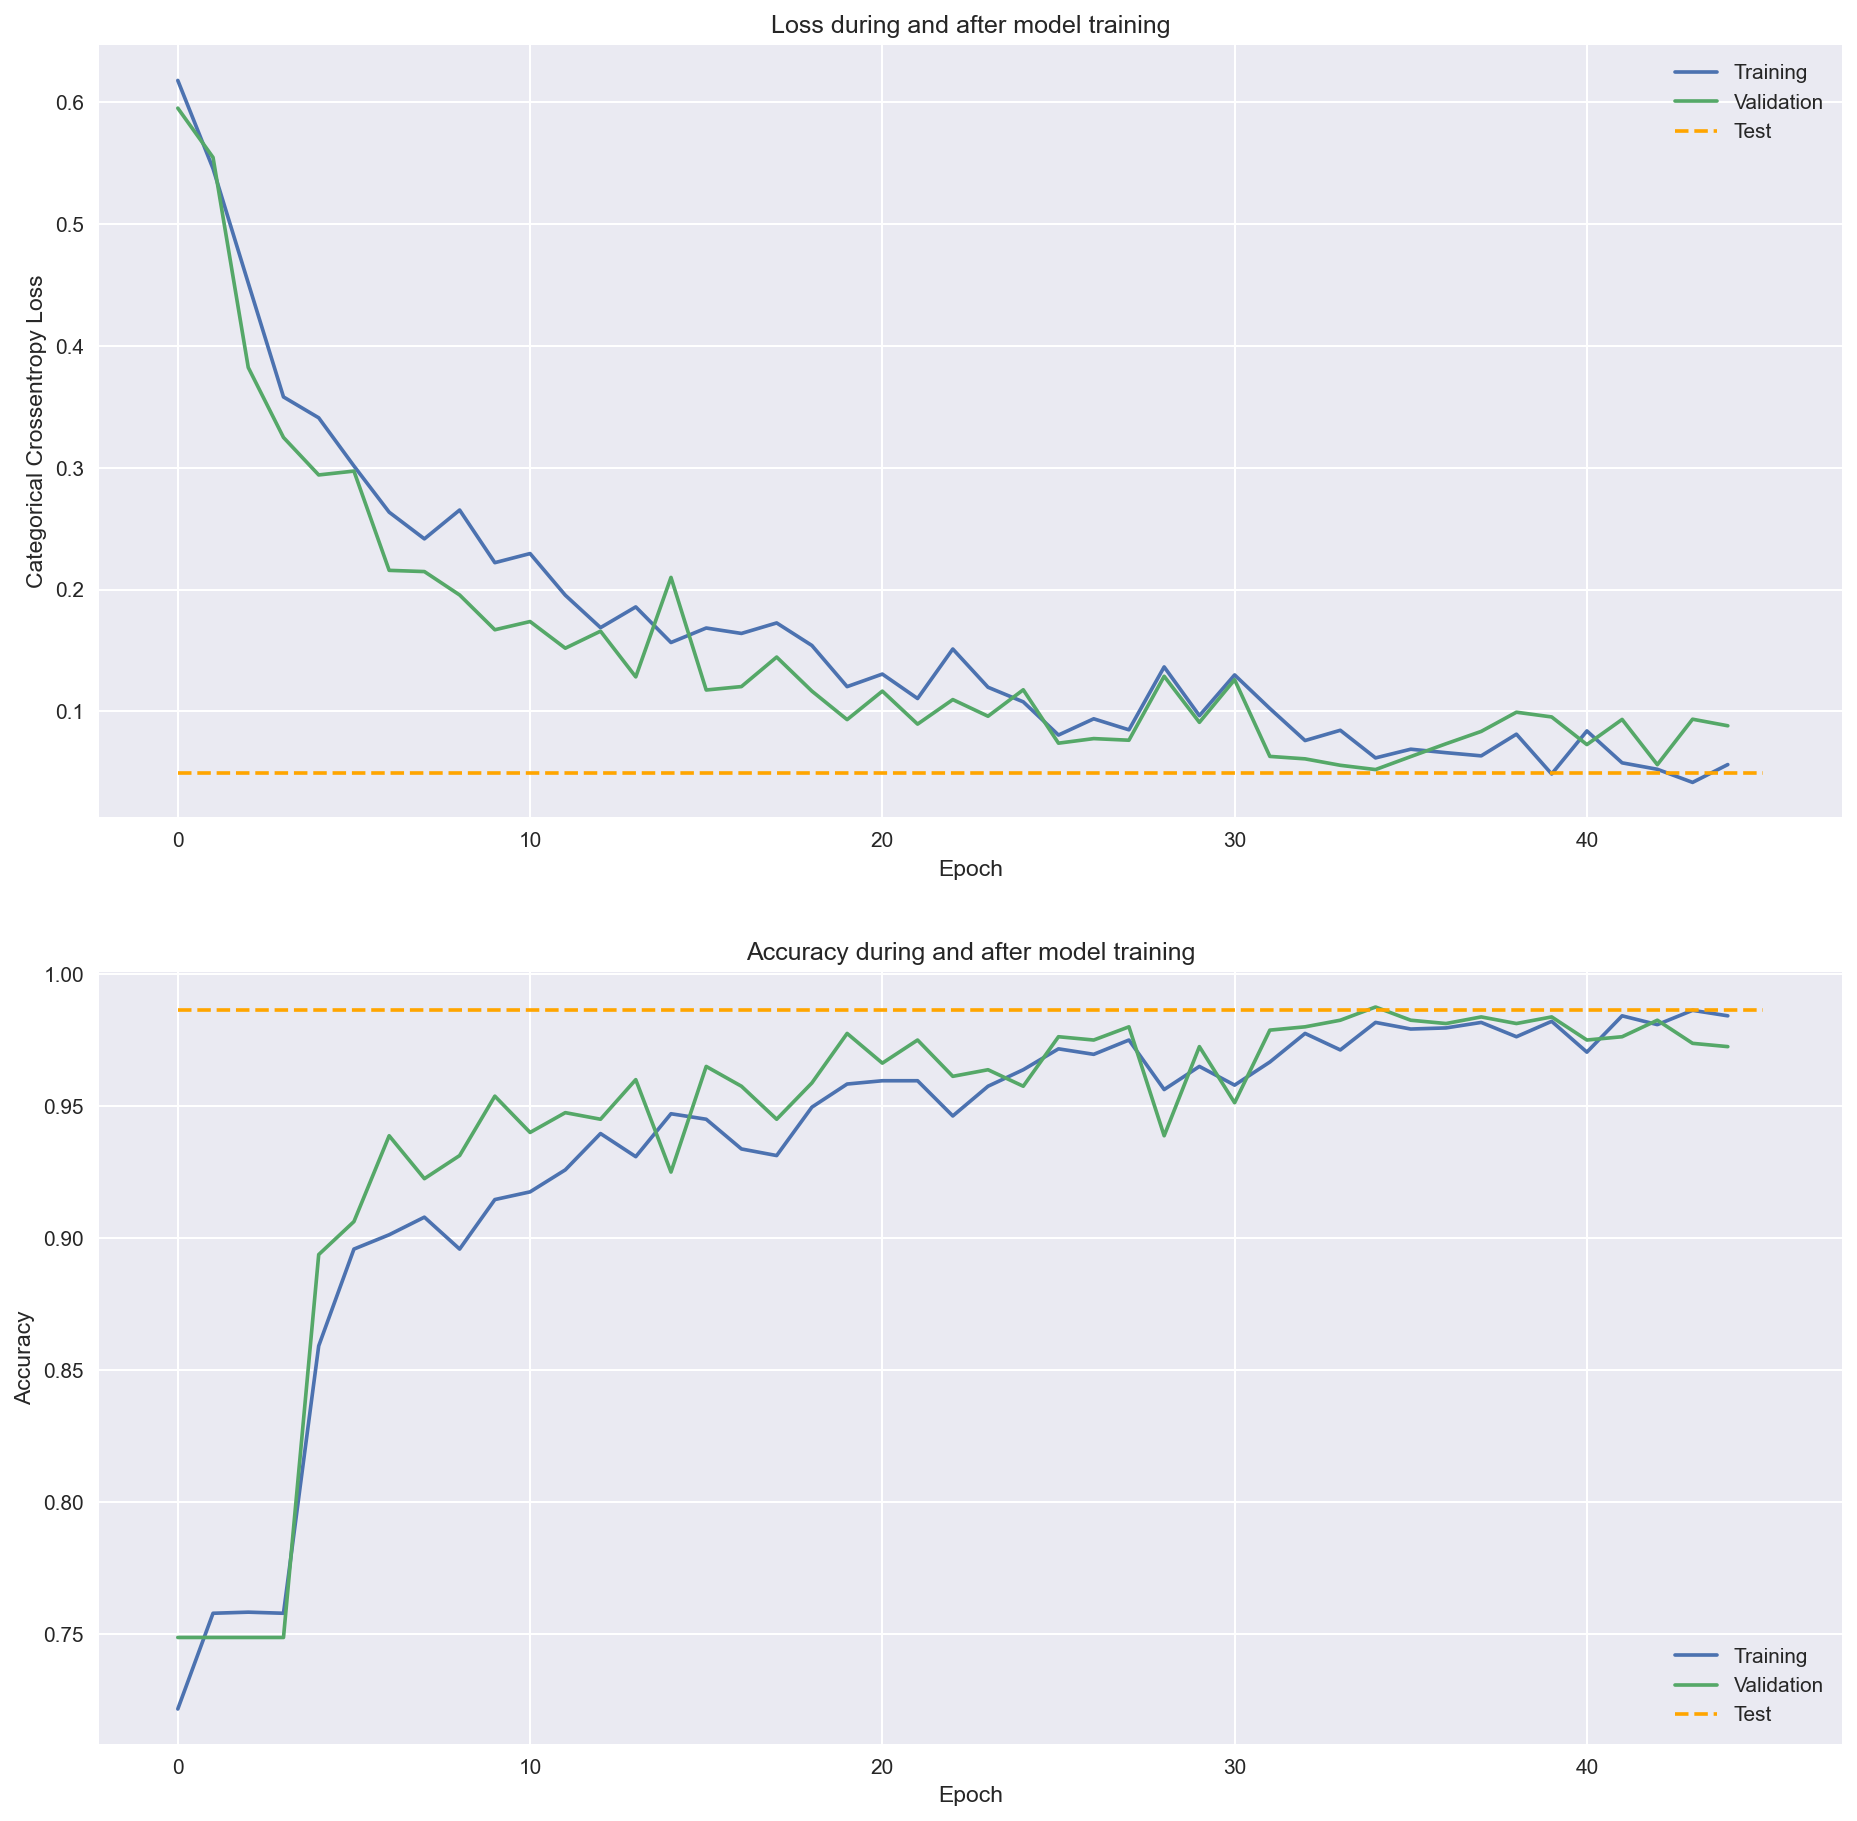

In [16]:
plt.figure(figsize=(15, 15), dpi=150)

# Loss graph
plt.subplot(211)
plt.plot(fit_history['loss'], label='Training')
plt.plot(fit_history['val_loss'], label='Validation')
plt.hlines(test_loss, 0, fit_history.shape[0], colors='orange', linestyles='--', label='Test')
plt.title('Loss during and after model training')
plt.xlabel('Epoch')
plt.ylabel('Categorical Crossentropy Loss')
plt.legend(loc='upper right')

# Accuracy graph
plt.subplot(212)
plt.plot(fit_history['accuracy'], label='Training')
plt.plot(fit_history['val_accuracy'], label='Validation')
plt.hlines(test_acc, 0, fit_history.shape[0], colors='orange', linestyles='--', label='Test')
plt.title('Accuracy during and after model training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()